In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fast')

# clustering functions
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

import utility_functions as fn

### Initialization

In [2]:
# import preprocessed electricity and weather data
elec = pd.read_csv('../data/elec_clean.csv',index_col=0)
elec.index = pd.to_datetime(elec.index,format='%Y-%m-%d %H:00:00')

weather = pd.read_csv('../data/weather_clean.csv',index_col=0)
weather.index = pd.to_datetime(weather.index,format='%Y-%m-%d %H:00:00')

### Normalizing the data

The clustering algorithm calculates the distance between each point of an array with other arrays like it. Here, there is an array for each building: a 24-entry array giving the average electricity demand for each hour of the day. For the algorithm to work, these arrays must be on the same scale, between 0 and 1.

In [3]:
# calculate the average day-of-week and hour-of-day profiles, then apply sklearn minmaxscaler
scaler = MinMaxScaler()

hour_of_day = elec.groupby(elec.index.hour).sum()
day_of_week = elec.groupby(elec.index.dayofweek).sum()
hour_of_day_norm = pd.DataFrame(scaler.fit_transform(hour_of_day.values),columns=hour_of_day.columns)
day_of_week_norm = pd.DataFrame(scaler.fit_transform(day_of_week.values),columns=day_of_week.columns)

### The hierarchical agglomerative clustering algorithm

This next cell applies the clustering algorithm, then plots a dendrogram of the results, and prints the cophenet clustering score, a common metric for the effectiveness of the result. For the hour-of-day curves, the score is great - any score above 0.75 is considered very good. The day of week clustering is much worse, meaning caution should be taken before using the results for further analysis.

The algorithm recommends creating four clusters based on the hour-of-day profiles (see color coding).

The cophenet clustering score is 0.863


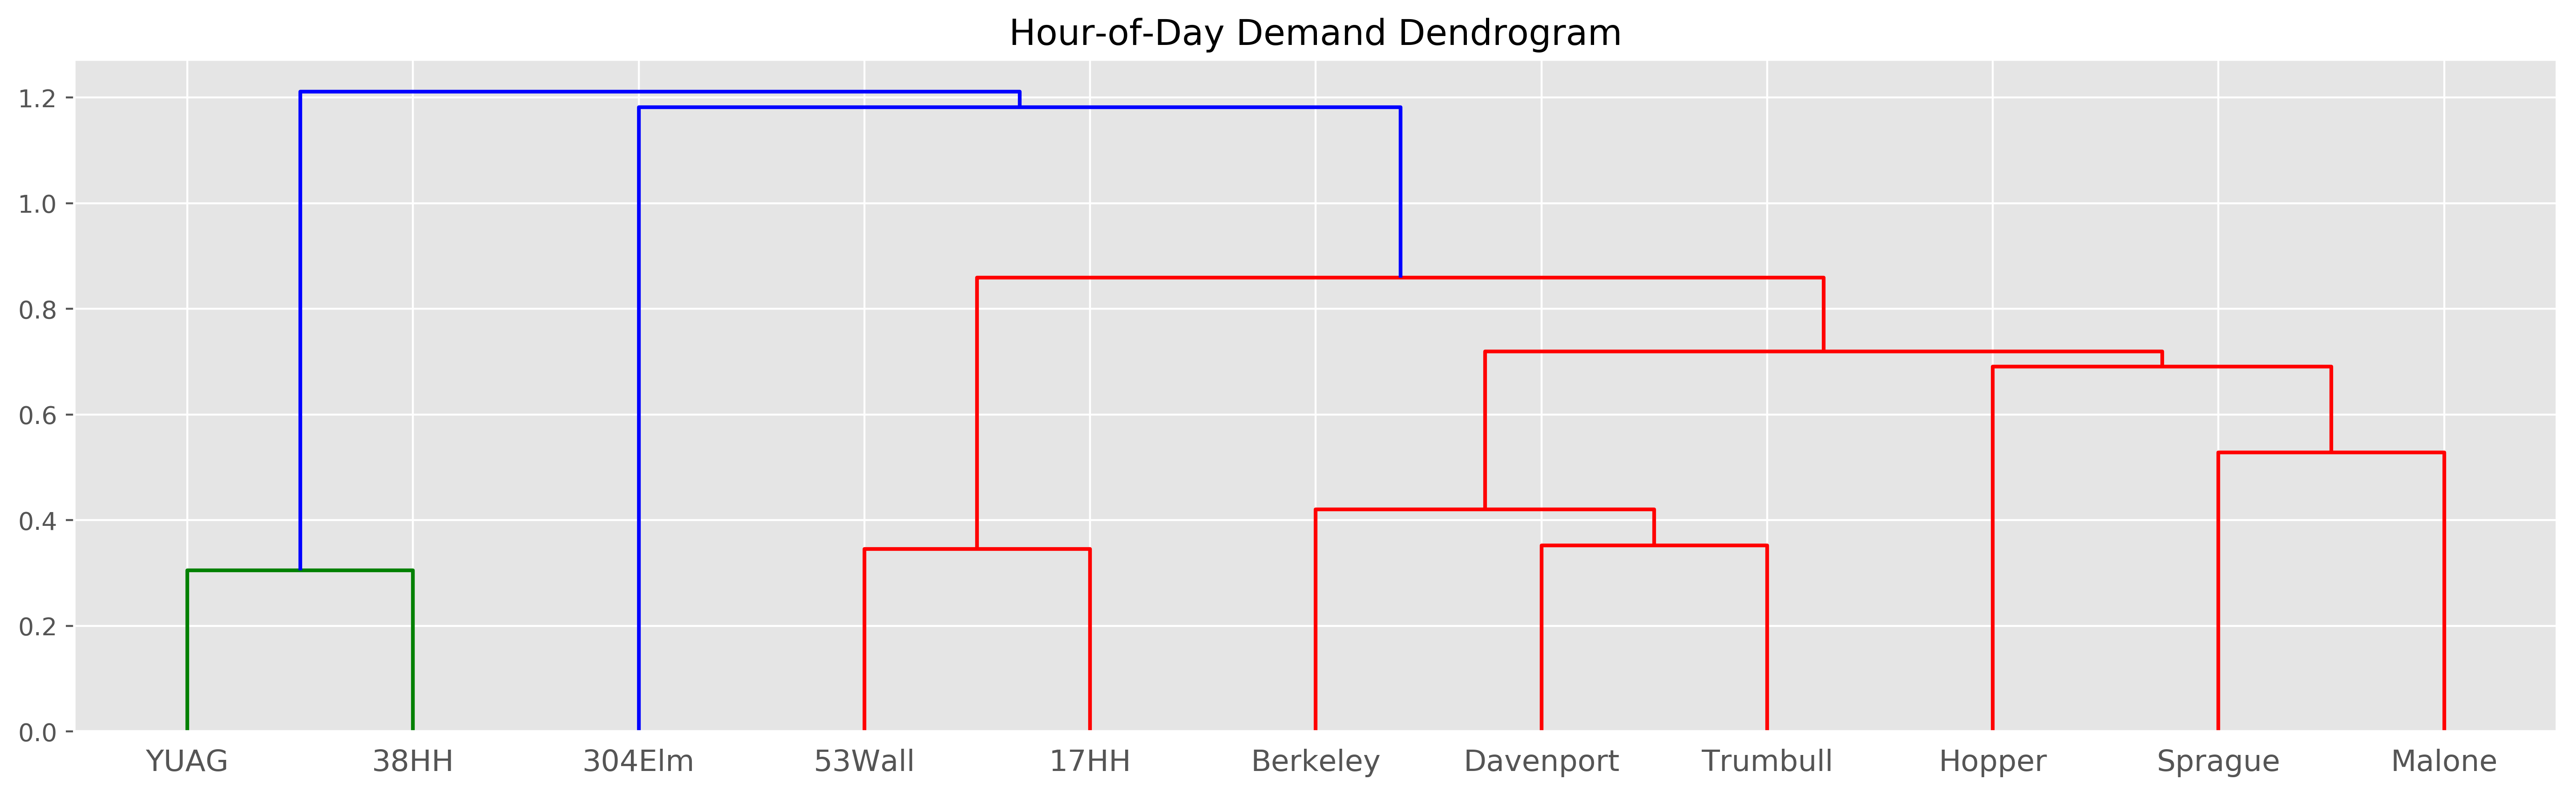

In [4]:
# create the hour-of-day linkage matrix hod_linkage
hod_linkage = hierarchy.linkage(hour_of_day_norm.values.T,'average')
labels = hour_of_day_norm.columns

# plot the dendrogram
fig, ax = plt.subplots(figsize=(18, 5),dpi=400)

# plt.figure(figsize=(18, 5),dpi=200)
hierarchy.dendrogram(hod_linkage,orientation='top',
                     labels=labels,
                     distance_sort='descending',
                     color_threshold=1,
                     ax=ax)

hierarchy.set_link_color_palette(['tab:red', 'tab:green', 'tab:orange', 'tab:orange'])

plt.title('Hour-of-Day Demand Dendrogram')

# export figure
fig.savefig('../figures/hour-of-day-dendrogram.png', bbox_inches='tight')

# calculate the cophenetic correlation coefficient, a clustering evaluation metric (>0.75 is good)
clustering_score, coph_dists = hierarchy.cophenet(hod_linkage, pdist(hour_of_day_norm.values.T))
print('The cophenet clustering score is {}'.format(np.round(clustering_score,3)))

The cophenet clustering score is 0.364


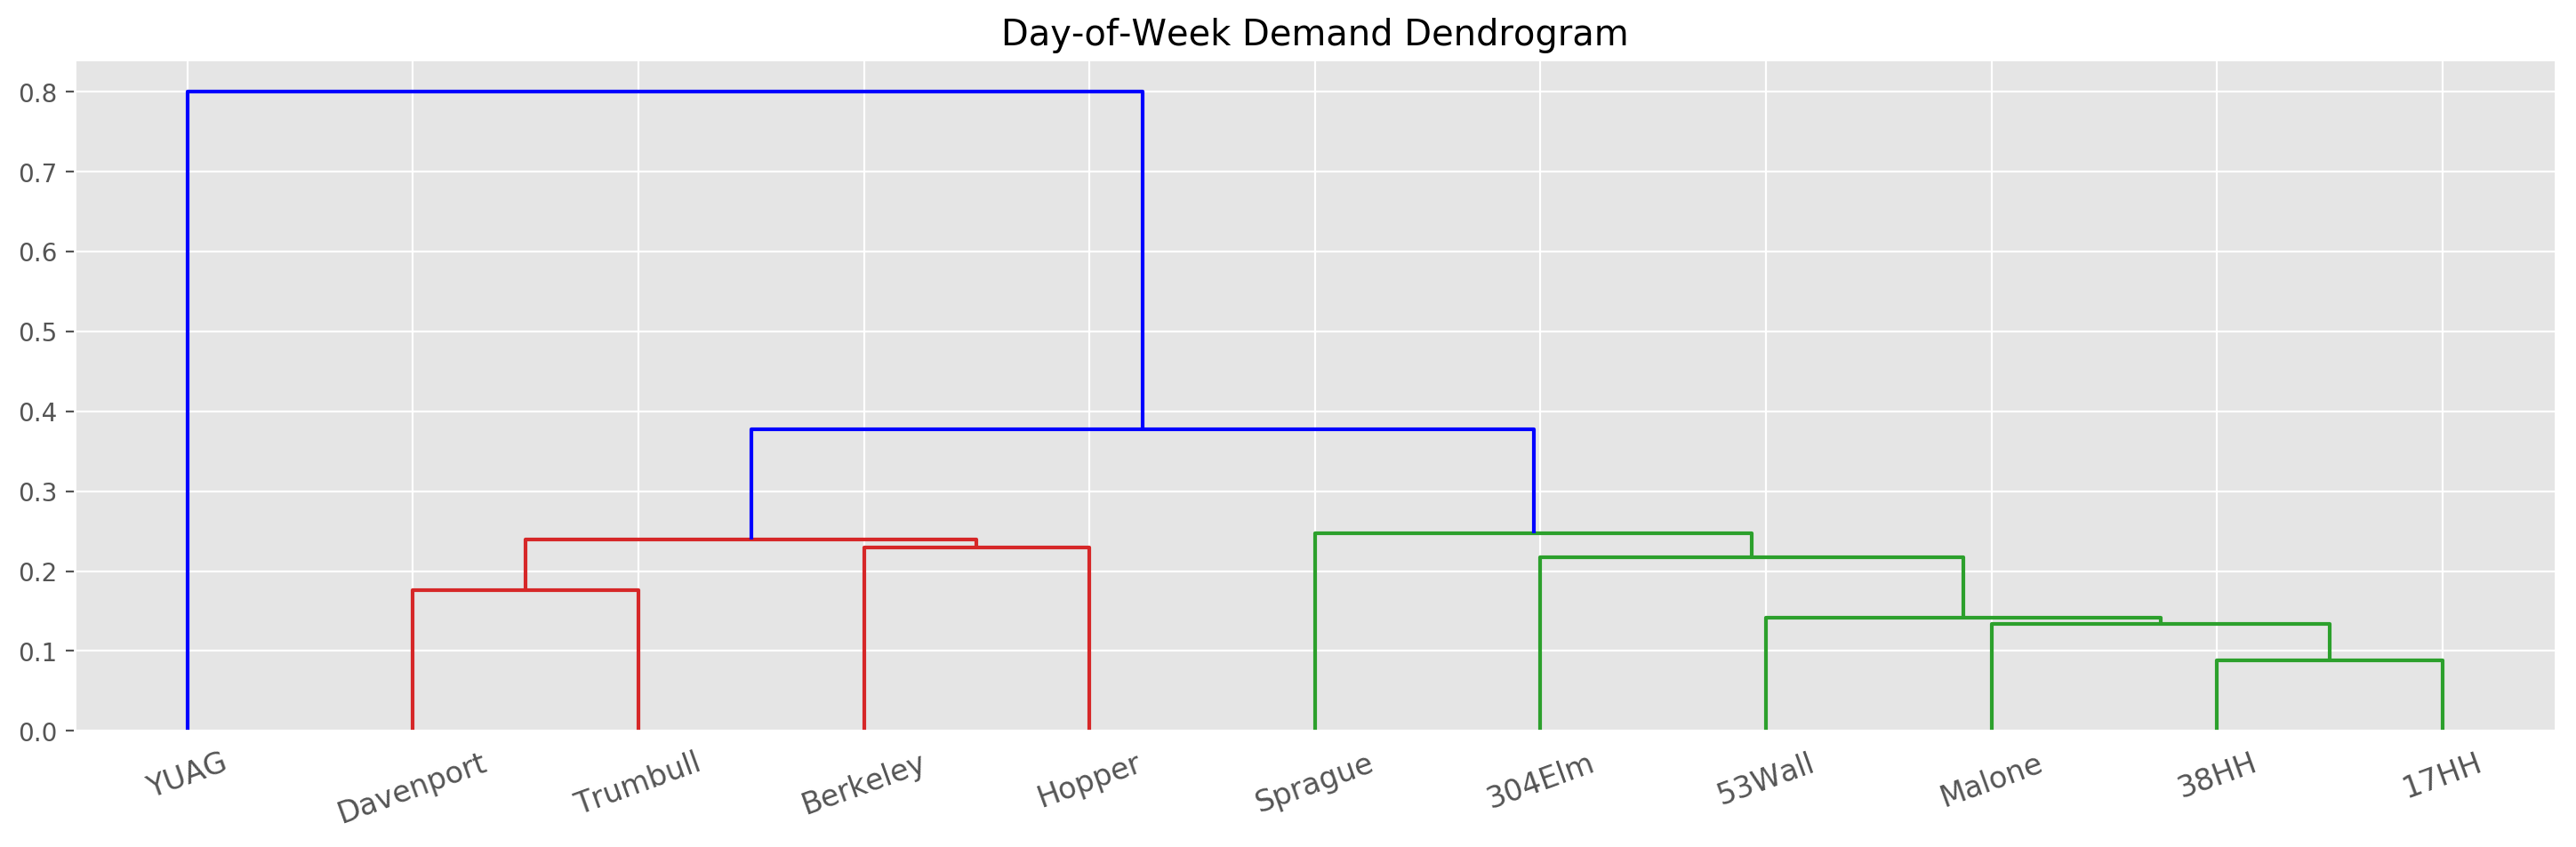

In [5]:
# repeat the process for the average day-of-week data
dow_linkage = hierarchy.linkage(day_of_week_norm.values.T,'average')
labels = day_of_week_norm.columns

plt.figure(figsize=(18,5),dpi=200)
hierarchy.set_link_color_palette(['tab:red', 'tab:green', 'tab:blue', 'tab:orange'])
hierarchy.dendrogram(dow_linkage,orientation='top',labels=labels,distance_sort='descending',color_threshold=0.3)
plt.xticks(rotation=20)
plt.title('Day-of-Week Demand Dendrogram')

clustering_score, coph_dists = hierarchy.cophenet(dow_linkage, pdist(hour_of_day_norm.values.T))
print('The cophenet clustering score is {}'.format(np.round(clustering_score,3)))

## Plots for export

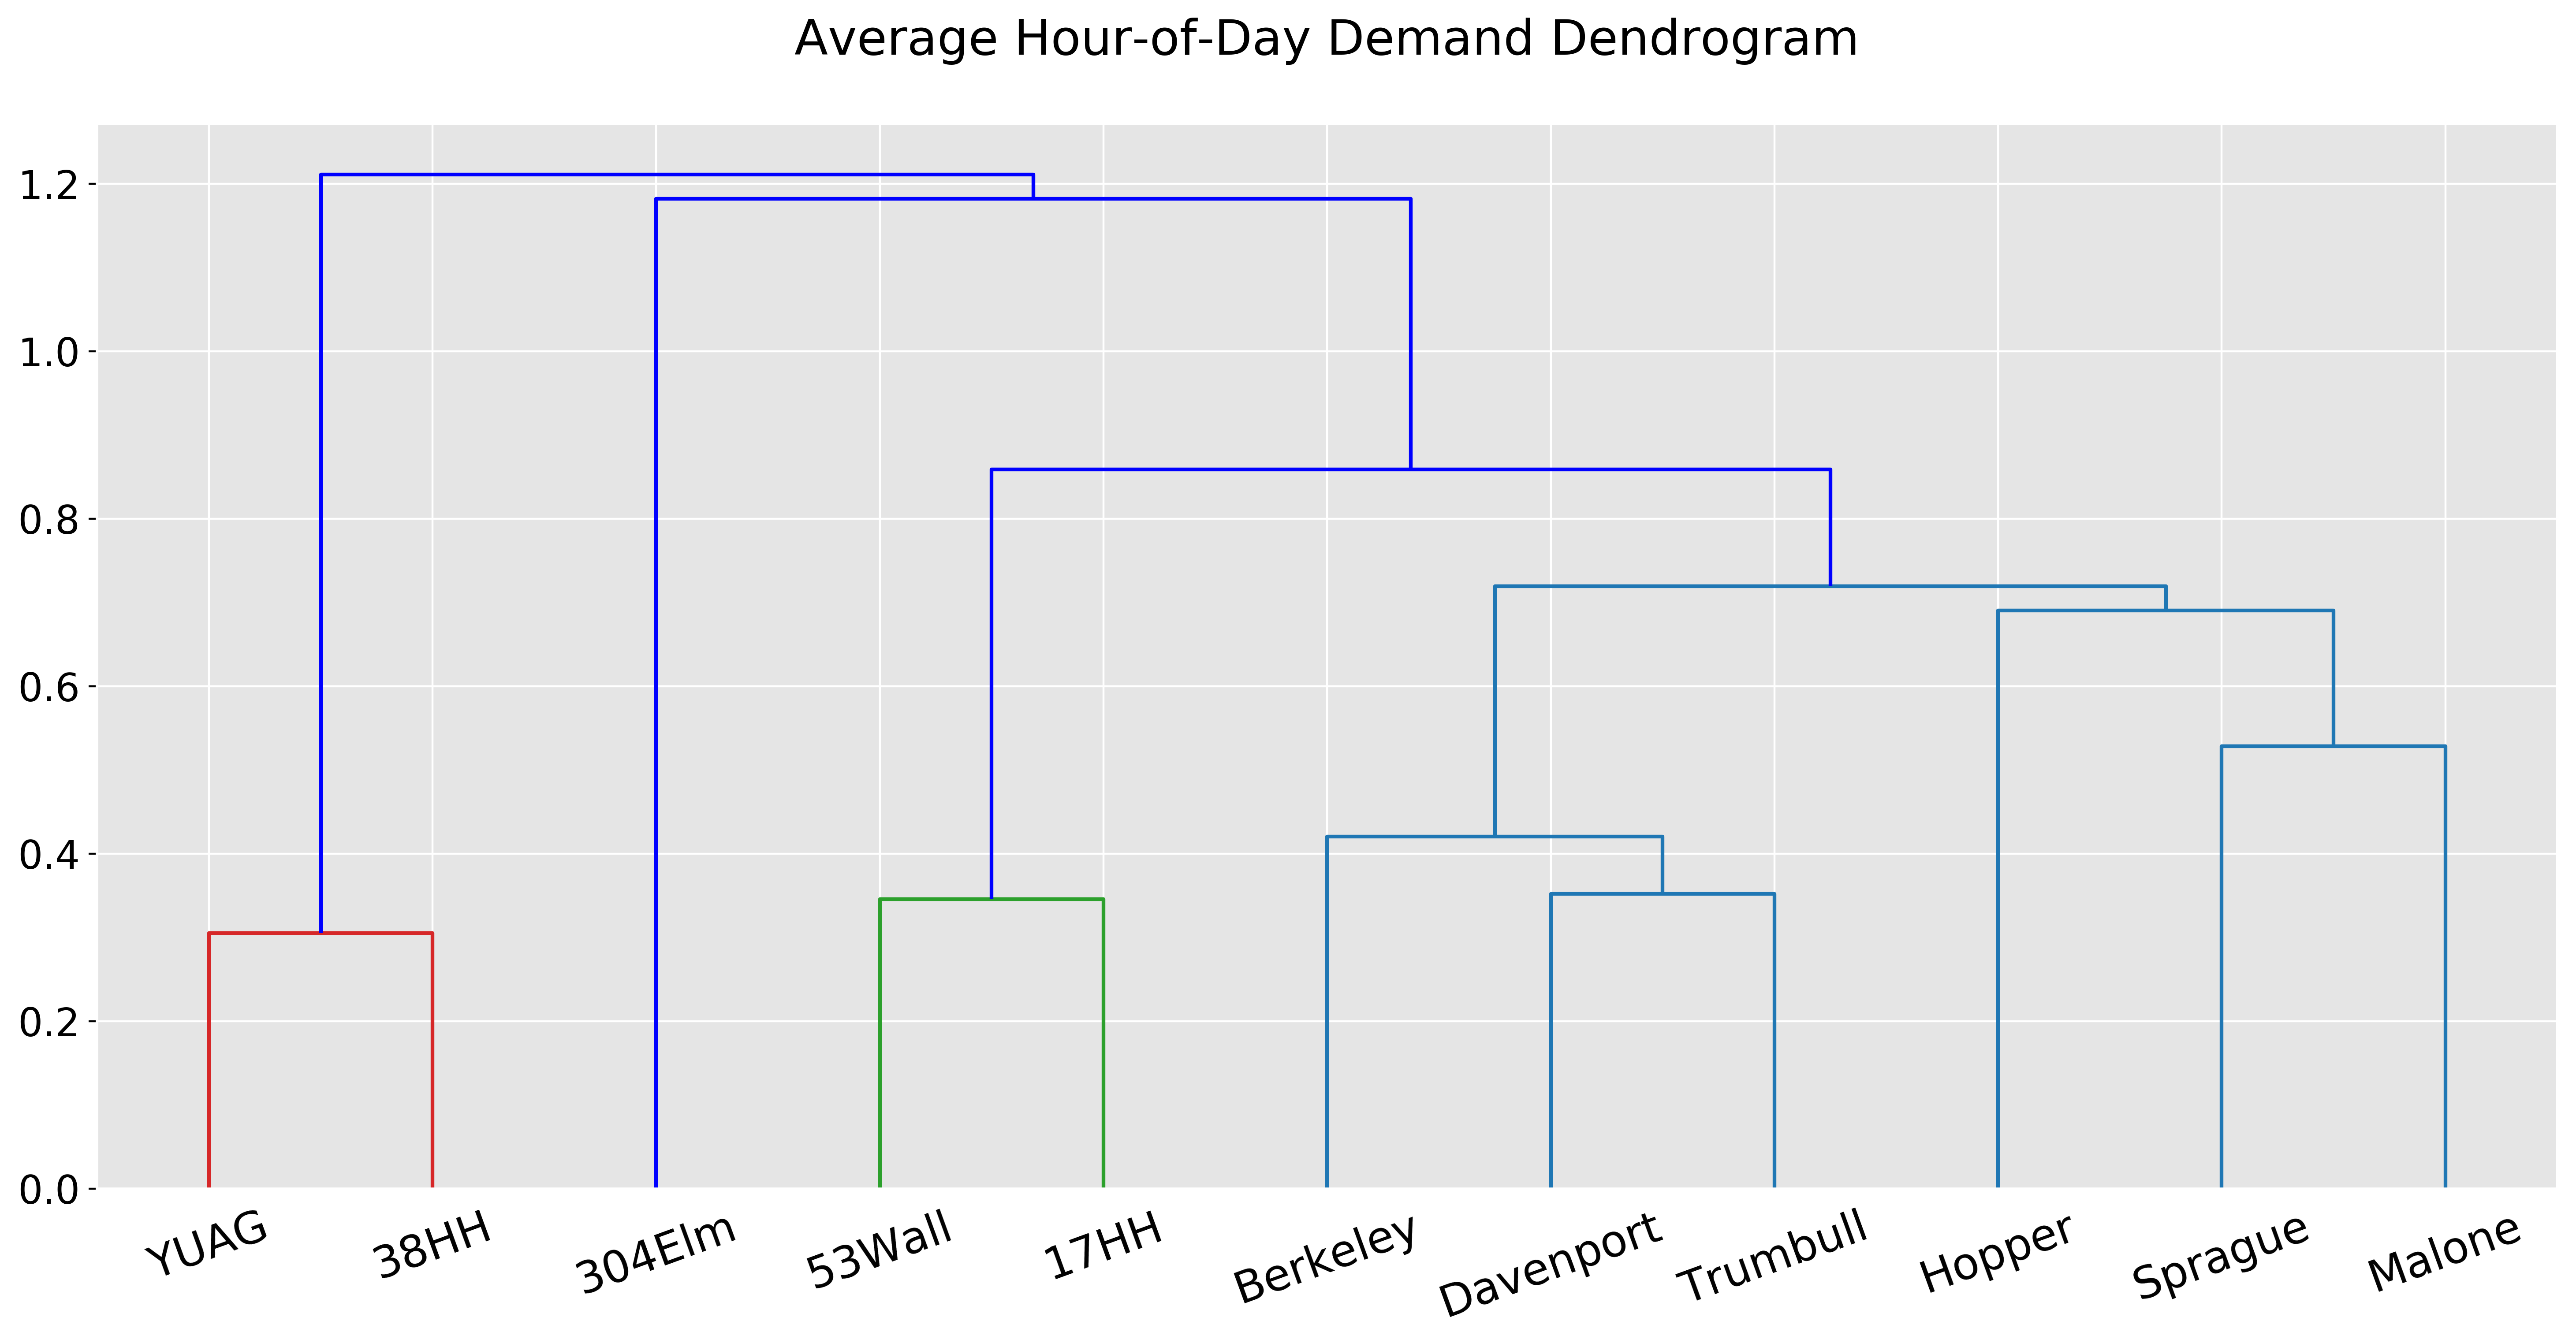

In [6]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(18,8),dpi=400)

hierarchy.dendrogram(hod_linkage,orientation='top',
                     labels=labels,
                     distance_sort='descending',
                     color_threshold=0.8,
                     ax=ax)

hierarchy.set_link_color_palette(['tab:red', 'tab:green', 'tab:orange', 'tab:orange'])

plt.title('Average Hour-of-Day Demand Dendrogram\n',size=20)

plt.xticks(rotation=20,color='k')
ax.tick_params(axis='x', colors='k',labelsize=18)
ax.tick_params(axis='y', colors='k',labelsize=16)
ax.xaxis.label.set_color('black')

# export figure
plt.savefig('../figures/hour-of-day-dendrogram.png', bbox_inches='tight')

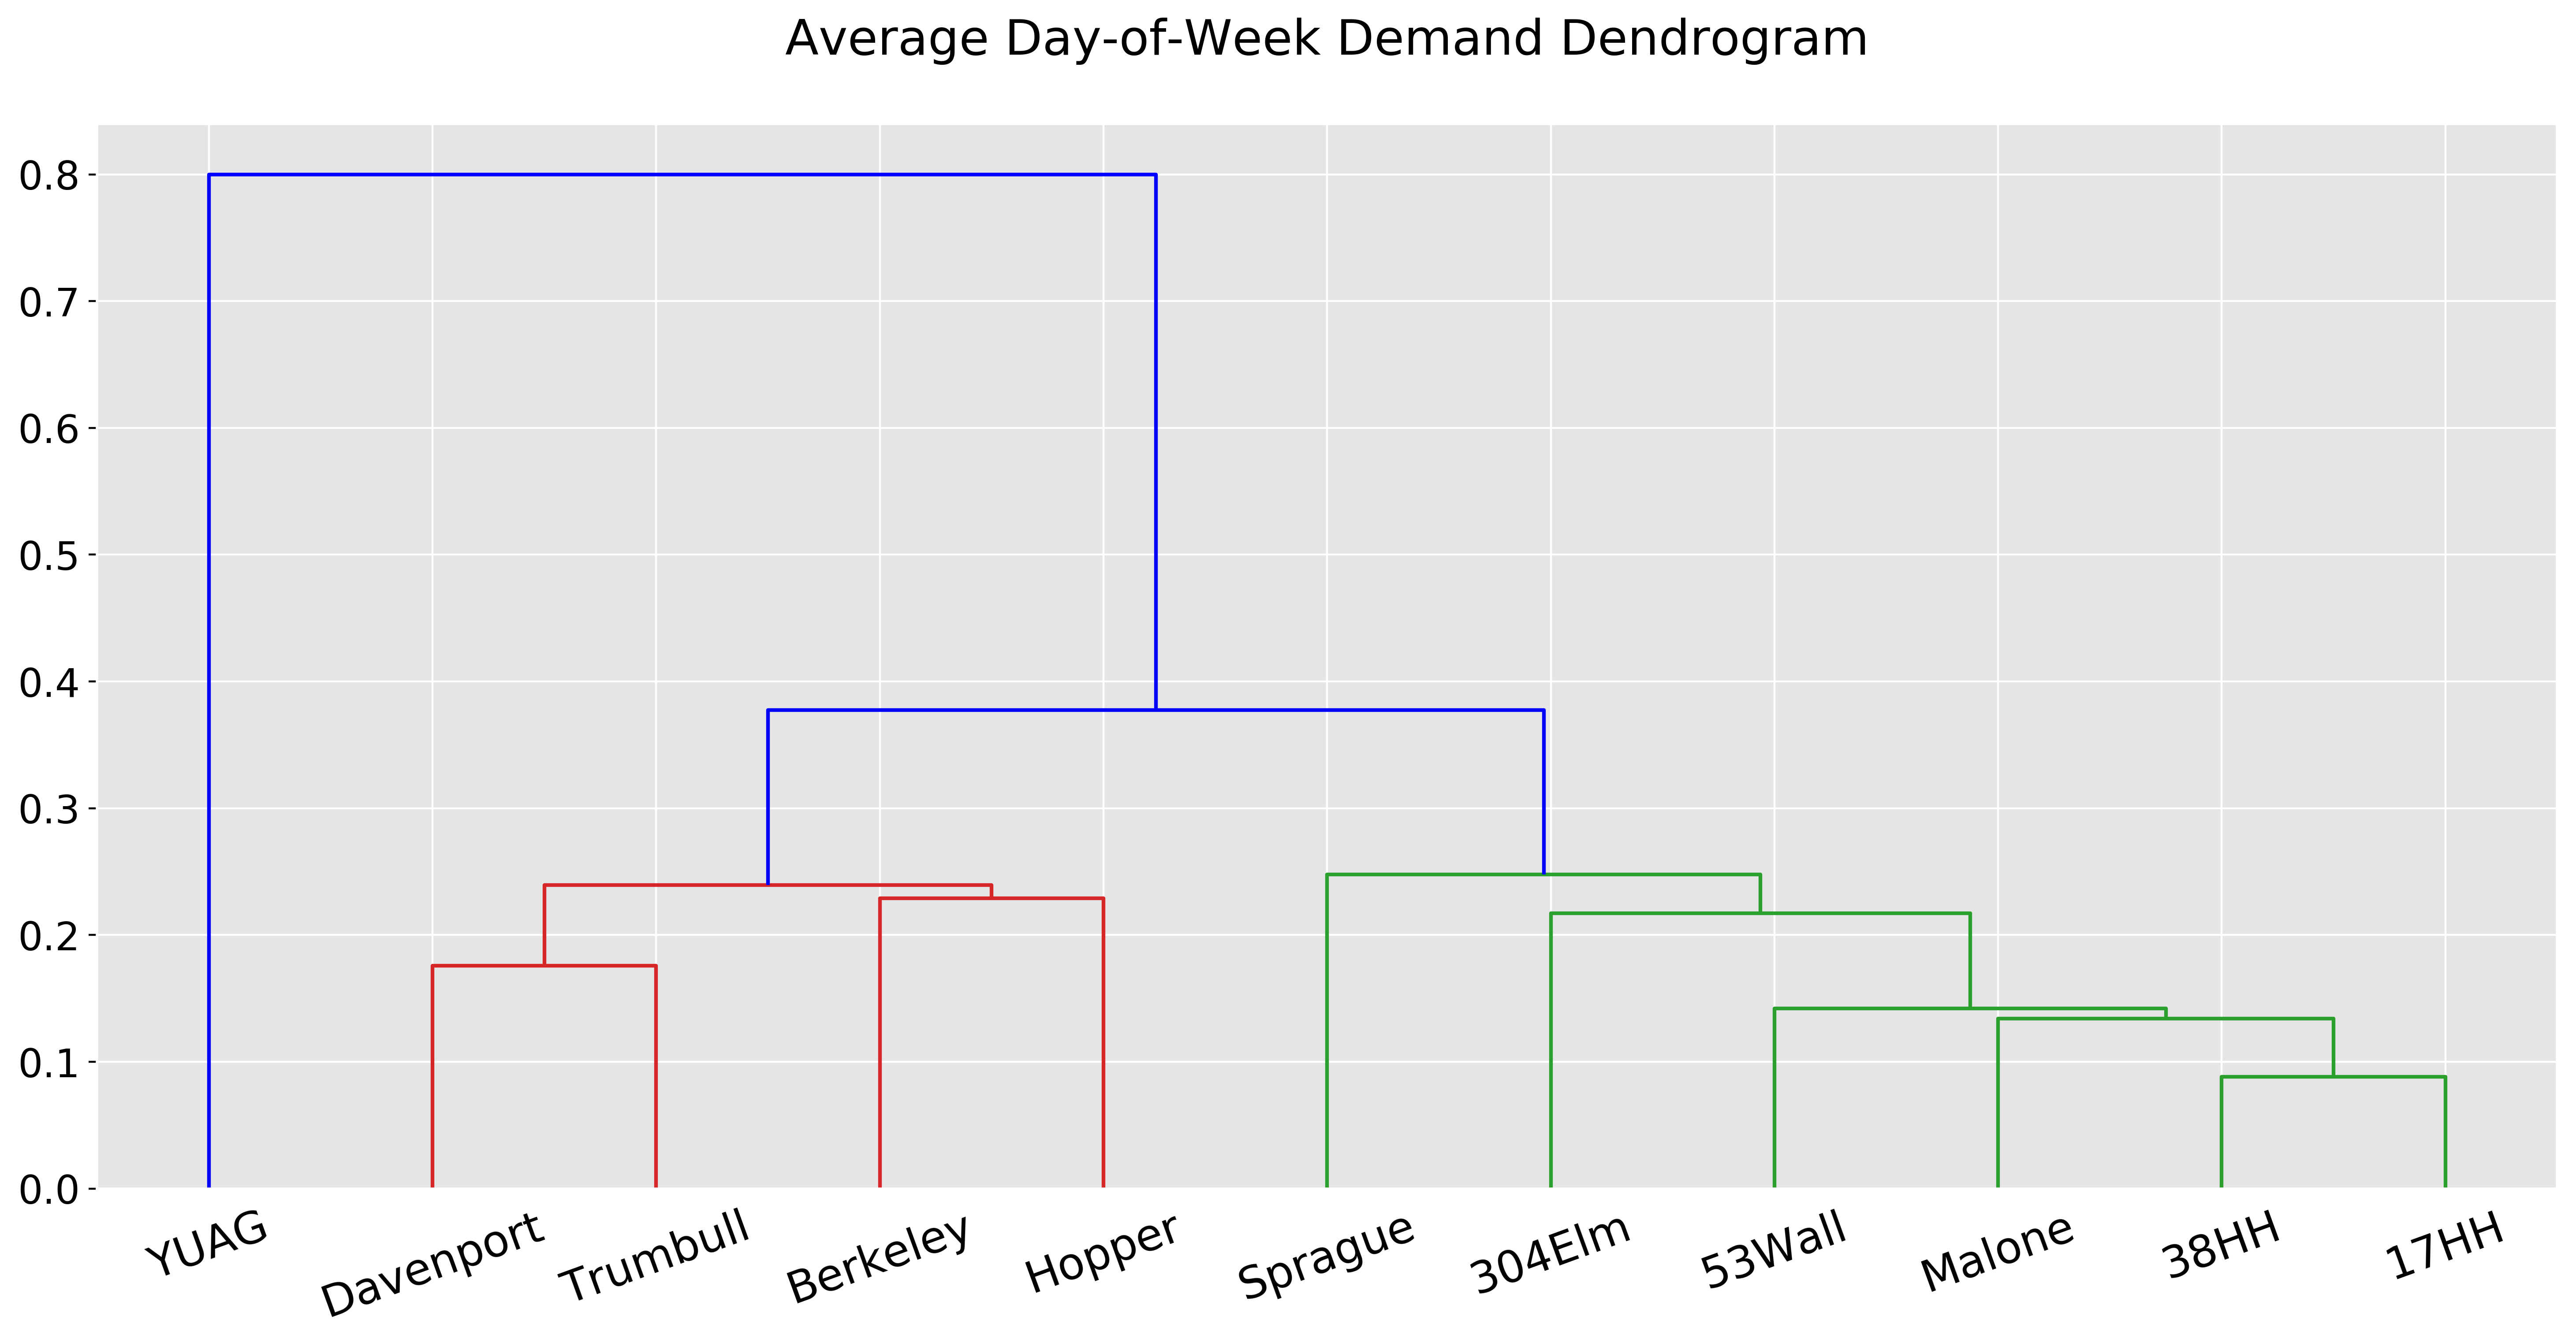

In [7]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(18,8),dpi=400)

hierarchy.dendrogram(dow_linkage,orientation='top',
                     labels=labels,
                     distance_sort='descending',
                     color_threshold=0.3,
                     ax=ax)

hierarchy.set_link_color_palette(['tab:red', 'tab:green', 'tab:orange', 'tab:orange'])

plt.title('Average Day-of-Week Demand Dendrogram\n',size=20)

plt.xticks(rotation=20,color='k')
ax.tick_params(axis='x', colors='k',labelsize=18)
ax.tick_params(axis='y', colors='k',labelsize=16)
ax.xaxis.label.set_color('black')

# export figure
plt.savefig('../figures/day-of-week-dendrogram.png', bbox_inches='tight')

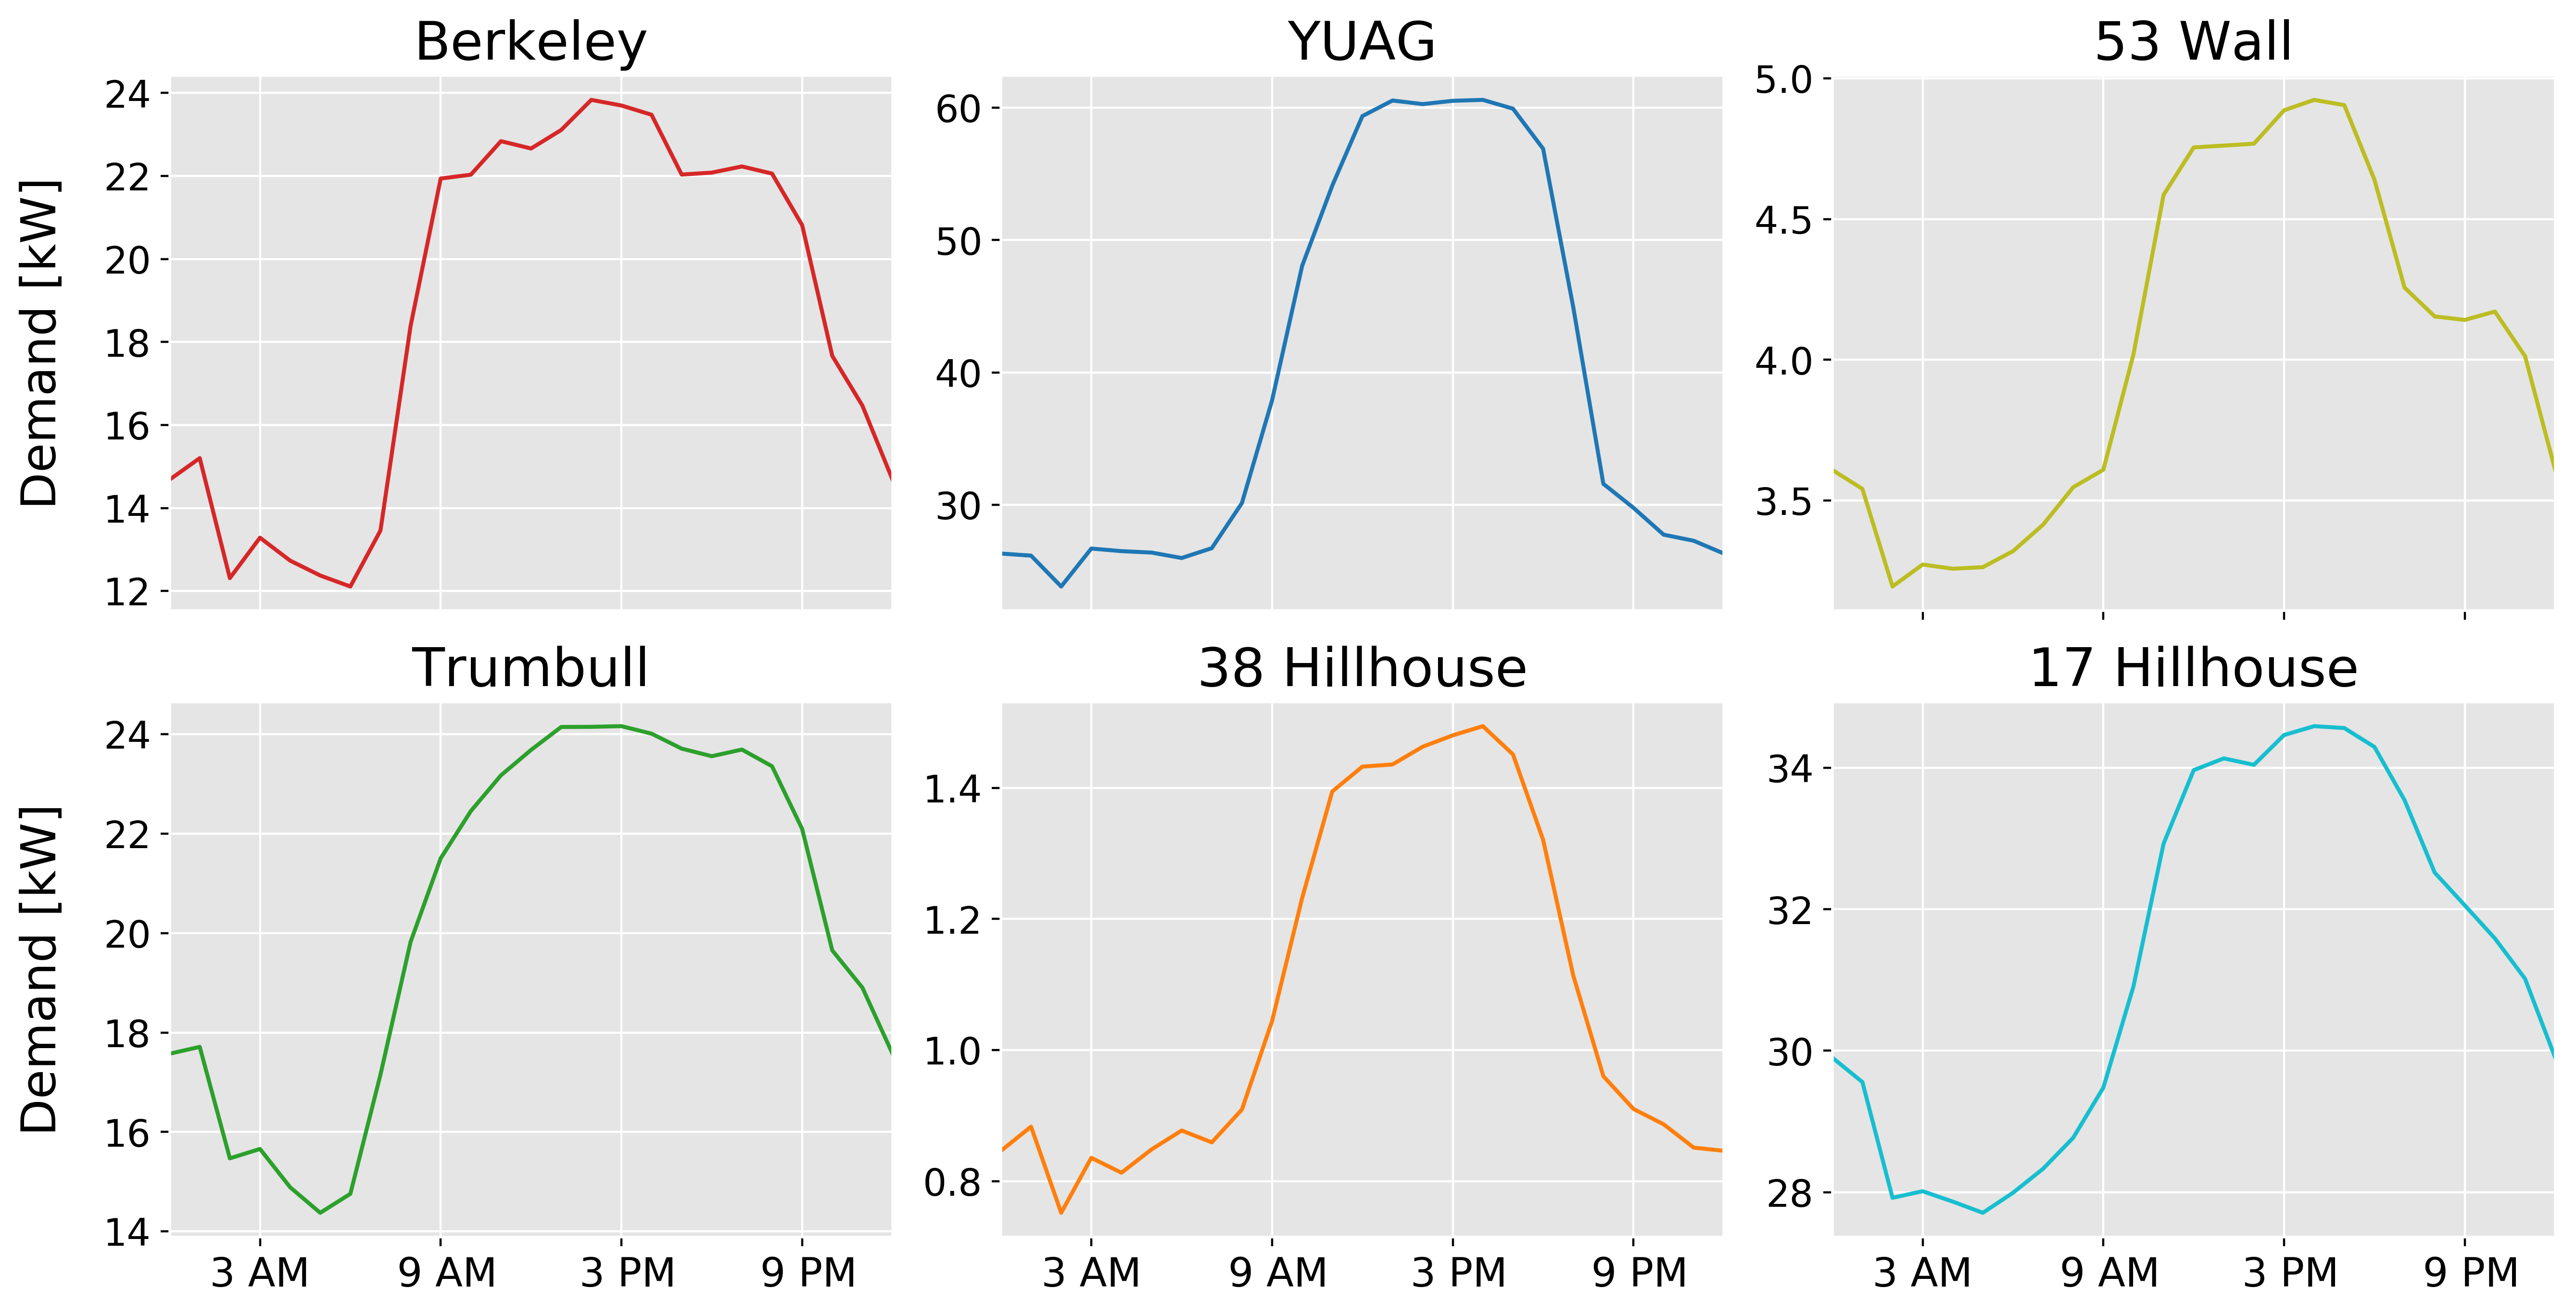

In [25]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('ggplot')

midnights = hour_of_day.head(1)
hour_of_day_wrapped = hour_of_day.append(midnights)

values1 = hour_of_day_wrapped['Berkeley']/1000
values2 = hour_of_day_wrapped['Trumbull']/1000
values3 = hour_of_day_wrapped['YUAG']/1000
values4 = hour_of_day_wrapped['38HH']/1000
values5 = hour_of_day_wrapped['53Wall']/1000
values6 = hour_of_day_wrapped['17HH']/1000

x_values = np.array(range(0,25))
# x_ticks = np.array(range(1,25,3))
# x_labels =  ['12 AM',' 3 AM',' 6 AM',' 9 AM',' 12 PM',' 3 PM',' 6 PM',' 9 PM']
x_ticks = np.array(range(3,24,6))
x_labels =  ['3 AM',' 9 AM',' 3 PM',' 9 PM']

fig, axes = plt.subplots(ncols=3,nrows=2,figsize=(16,8),dpi=400,sharex=True)
plt.xticks(x_ticks,x_labels,color='k')
plt.xlim(0,24)
fig.subplots_adjust(wspace=0.15,hspace=0.17)

axes[0,0].plot(x_values,values1,color='tab:red')
axes[0,0].set_title('Berkeley',size=20)
axes[0,0].set_ylabel('Demand [kW]',color='k',size=18,labelpad=14)
axes[0,0].tick_params(axis='x',colors='k',size=0)
axes[0,0].tick_params(axis='y',colors='k',labelsize=14)

axes[1,0].plot(x_values,values2,color='tab:green')
axes[1,0].set_title('Trumbull',size=20)
axes[1,0].set_ylabel('Demand [kW]',color='k',size=18,labelpad=14)
# axes[1,0].set_ylim(13.2,25)
axes[1,0].tick_params(axis='x',colors='k',labelsize=15)
axes[1,0].tick_params(axis='y',colors='k',labelsize=14)

axes[0,1].plot(x_values,values3,color='tab:blue')
axes[0,1].set_title('YUAG',size=20)
# axes[0,1].set_ylim(18,64)
# axes[0,1].set_yticks([20,30,40,50,60])
axes[0,1].tick_params(axis='x',colors='k',size=0)
axes[0,1].tick_params(axis='y',colors='k',labelsize=14)

axes[1,1].plot(x_values,values4,color='tab:orange')
axes[1,1].set_title('38 Hillhouse',size=20)
# axes[1,1].set_ylim(0.63,1.58)
# axes[1,1].set_yticks([0.7,0.9,1.1,1.3,1.5])
axes[1,1].tick_params(axis='x',colors='k',labelsize=15)
axes[1,1].tick_params(axis='y',colors='k',labelsize=14)

axes[0,2].plot(x_values,values5,color='tab:olive')
axes[0,2].set_title('53 Wall',size=20)
# axes[0,2].set_ylim(0.63,1.58)
# axes[0,2].set_yticks([0.7,0.9,1.1,1.3,1.5])
axes[0,2].tick_params(axis='x',colors='k',labelsize=15)
axes[0,2].tick_params(axis='y',colors='k',labelsize=14)

axes[1,2].plot(x_values,values6,color='tab:cyan')
axes[1,2].set_title('17 Hillhouse',size=20)
# axes[1,2].set_ylim(0.63,1.58)
# axes[1,2].set_yticks([0.7,0.9,1.1,1.3,1.5])
axes[1,2].tick_params(axis='x',colors='k',labelsize=15)
axes[1,2].tick_params(axis='y',colors='k',labelsize=14)


fig.savefig('../figures/cluster_example.png', bbox_inches='tight')
